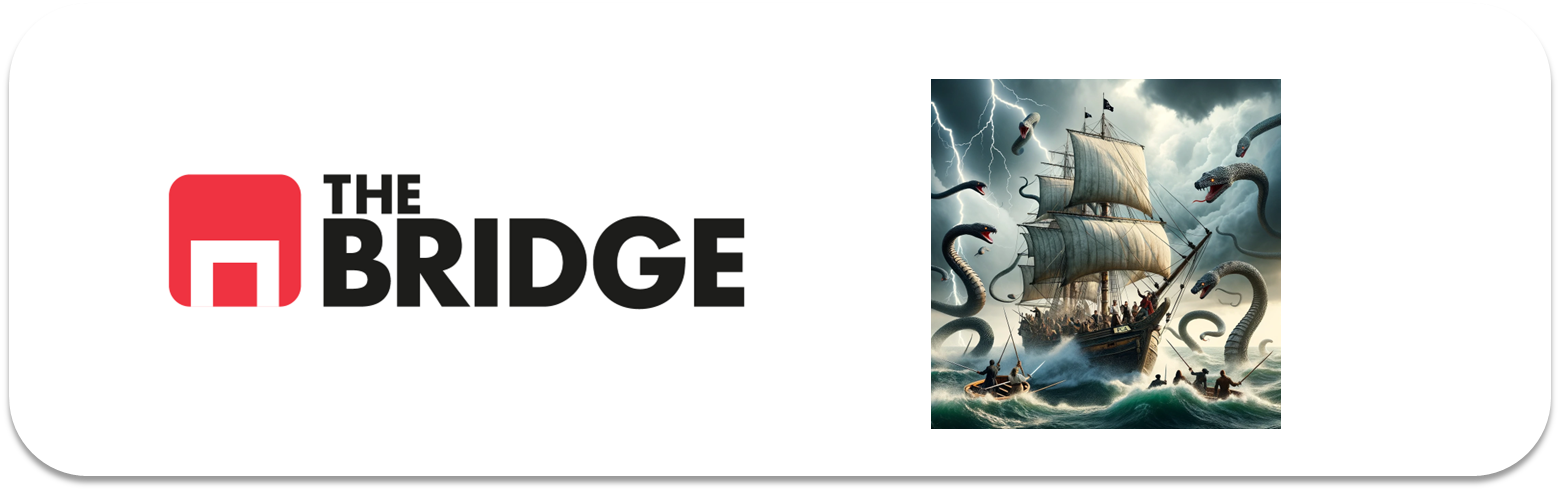

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

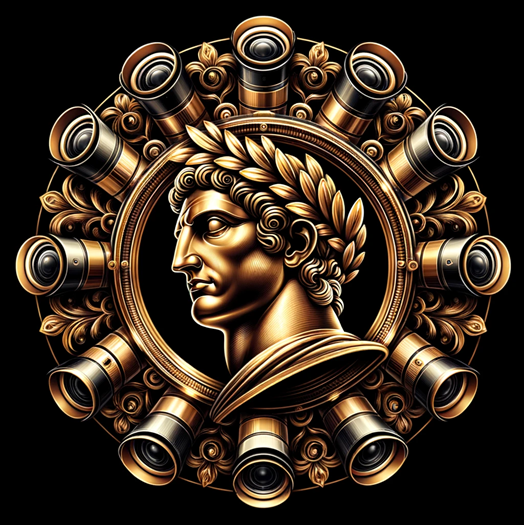

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from utils import functions as fun

# Ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




### Dataset Olivetti

In [2]:
# Cargar el conjunto de datos de Olivetti Faces
olivetti_faces = fetch_olivetti_faces()

# Mostrar la descripción del conjunto de datos
print(olivetti_faces['DESCR'])


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [3]:
olivetti_faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [4]:
# Extraer las imágenes y el target
data = olivetti_faces['data']
target = olivetti_faces['target']

# Crear un dataframe con las imágenes y añadir la columna 'target'
df_images = pd.DataFrame(data)
df_images['target'] = target

df_images.sample(5)


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
362,0.219008,0.227273,0.396694,0.487603,0.504132,0.512397,0.537190,0.599174,0.615702,0.595041,...,0.252066,0.231405,0.173554,0.161157,0.169421,0.181818,0.243802,0.252066,0.289256,36
88,0.429752,0.475207,0.520661,0.549587,0.553719,0.586777,0.628099,0.652893,0.669421,0.665289,...,0.342975,0.359504,0.371901,0.338843,0.351240,0.367769,0.355372,0.392562,0.376033,8
145,0.495868,0.533058,0.578512,0.603306,0.574380,0.615702,0.611570,0.640496,0.652893,0.640496,...,0.549587,0.516529,0.524793,0.512397,0.495868,0.500000,0.479339,0.454545,0.450413,14
249,0.640496,0.681818,0.719008,0.731405,0.739669,0.764463,0.776860,0.785124,0.797521,0.785124,...,0.466942,0.458678,0.318182,0.305785,0.202479,0.326446,0.409091,0.421488,0.417355,24
200,0.516529,0.512397,0.508264,0.516529,0.537190,0.566116,0.561983,0.574380,0.578512,0.582645,...,0.086777,0.099174,0.136364,0.334711,0.520661,0.557851,0.561983,0.557851,0.566116,20


### Split de train y test

In [5]:
train_set, test_set = train_test_split(df_images, test_size=0.2, stratify=df_images['target'], random_state=42)
print(train_set.shape, test_set.shape)

X_train = train_set.drop(columns=['target'])
X_test = test_set.drop(columns=['target'])

y_train = train_set['target']
y_test = test_set['target']

print(y_train.value_counts(True))


(320, 4097) (80, 4097)
target
13    0.025
5     0.025
8     0.025
0     0.025
28    0.025
6     0.025
31    0.025
21    0.025
38    0.025
25    0.025
26    0.025
4     0.025
30    0.025
18    0.025
39    0.025
14    0.025
17    0.025
27    0.025
29    0.025
34    0.025
22    0.025
15    0.025
1     0.025
3     0.025
12    0.025
10    0.025
20    0.025
24    0.025
35    0.025
11    0.025
9     0.025
23    0.025
37    0.025
32    0.025
36    0.025
33    0.025
16    0.025
19    0.025
7     0.025
2     0.025
Name: proportion, dtype: float64


### Mini-EDA

In [6]:
print(X_train.shape)
print(y_train.shape)

X_train.describe()

(320, 4096)
(320,)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,0.402415,0.435873,0.478022,0.520868,0.558458,0.594202,0.626860,0.652131,0.667975,0.677299,...,0.361919,0.365315,0.360860,0.352247,0.331831,0.332658,0.335640,0.323631,0.315457,0.310563
std,0.181016,0.189294,0.194538,0.193381,0.185826,0.172860,0.160770,0.149373,0.143260,0.142931,...,0.163522,0.179647,0.179781,0.187285,0.180302,0.184645,0.193152,0.188717,0.181919,0.179779
min,0.086777,0.066116,0.090909,0.041322,0.111570,0.107438,0.115702,0.115702,0.119835,0.140496,...,0.049587,0.037190,0.053719,0.049587,0.033058,0.012397,0.049587,0.057851,0.061983,0.033058
25%,0.246901,0.267562,0.314050,0.383264,0.456612,0.516529,0.545455,0.582645,0.602273,0.611570,...,0.230372,0.217975,0.209711,0.197314,0.177686,0.177686,0.173554,0.173554,0.177686,0.173554
50%,0.400826,0.460744,0.512397,0.549587,0.586777,0.615702,0.657025,0.671488,0.683884,0.702479,...,0.367769,0.365702,0.347107,0.334711,0.309917,0.301653,0.301653,0.293388,0.278926,0.270661
75%,0.530992,0.574380,0.632231,0.669421,0.699380,0.714876,0.735537,0.757231,0.772727,0.777893,...,0.480372,0.495868,0.496901,0.488636,0.455579,0.455579,0.462810,0.446281,0.418388,0.417355
max,0.805785,0.822314,0.871901,0.855372,0.863636,0.863636,0.871901,0.867769,0.871901,0.871901,...,0.793388,0.904959,0.888430,0.896694,0.826446,0.785124,0.921488,0.929752,0.884298,0.822314


In [7]:
y_train.unique()


array([13,  5,  3, 12, 10, 20, 24, 35, 11,  1,  9, 37, 32, 36, 33, 16, 19,
        7, 23, 15, 22, 34,  8,  0, 28,  6, 31, 21, 38, 25, 26,  4, 30, 18,
       39, 14, 17, 27, 29,  2])

Este set de datos representa imagenes en blanco y negro de 64x54 pixeles ( que son las features ), aplanados (por eso son 4096 columnas).

Los datos ya están prácticamente normalizados entre 0 (min) y 1 (max), aunque no llegan a estos valores. Probablemente porque al ser fotografías reales se habrá dividido entre 255 para normalizarlo. En fotografías en blanco y negro la escala es [0, 255], es decir 256 tonos. Por tanto no se va a hacer ninguna transformación más.

Por su parte el target son las caras de 40 personas diferentes. Cada persona tiene 10 fotos en el dataset original.


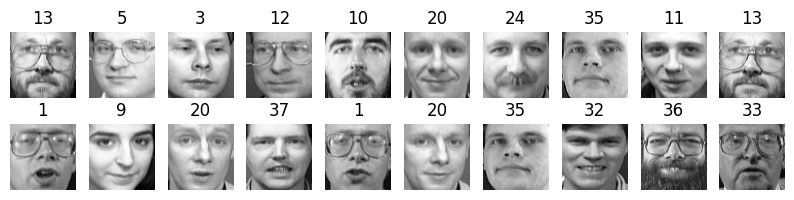

In [8]:
# Pintar caras
fun.plot_faces(X_train.iloc[:20].to_numpy(), y_train.iloc[:20].to_numpy())

### Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes

Por su simplicidad voy a usar un modelo KNN y un RandomForest como baseline. 

Para RandomForestClassifier voy a limitar la profundidad al logaritmo en base 2 del número de targets diferentes + 1 (para redondear).
Porque esto querría decir que en cada ramificación como salen 2 opciones, en el último nivel hemos clasificado perfectamente todos los casos. Cada rama multiplica por 2 las condiciones.

In [9]:
# Limitar la profundida del árbol a 1
max_depth = int(np.log2(y_train.nunique()) + 1)

knn_base = KNeighborsClassifier()
rf_base = RandomForestClassifier(max_depth=max_depth, random_state=42)

# 5-fold cross-validation
cv_knn_score = cross_val_score(knn_base, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
cv_rf_score = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()

# Entrenar el modelo en todo el conjunto de entrenamiento
knn_base.fit(X_train, y_train)
rf_base.fit(X_train, y_train)

test_knn_score = balanced_accuracy_score(y_test, knn_base.predict(X_test))
test_rf_score = balanced_accuracy_score(y_test, rf_base.predict(X_test))

# Guardar las métricas (por ejemplo, en un diccionario)
metrics = {
    'cv_knn_score': cv_knn_score,
    'test_knn_score': test_knn_score,
    'cv_rf_score': cv_rf_score,
    'test_rf_score': test_rf_score
}

display(metrics)

{'cv_knn_score': 0.7725,
 'test_knn_score': 0.85,
 'cv_rf_score': 0.7075,
 'test_rf_score': 0.75}

Me gusta más el resultado de KNN, así que me quedaré con él.

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

### Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).

In [10]:
pca = PCA()
pca.fit(X_train)

# Veremos que mantiene la dimensión
pca.components_.shape

(320, 4096)

### Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). 

NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)

In [11]:
# Valores de compresión (en porcentaje)
compression_ratios = [0.2, 0.5, 1.0, 1.5, 2.0, 2.5]
results = []

for ratio in compression_ratios:
    n_components = int(X_train.shape[1] * (ratio / 100))
    
    # Aplicar PCA con el número de componentes seleccionado
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Validación cruzada con 5 folds
    knn_pca = KNeighborsClassifier()
    cv_pca_score = cross_val_score(knn_pca, X_train_pca, y_train, cv=5, scoring='balanced_accuracy').mean()
    
    # Entrenar y evaluar en el conjunto de test
    knn_pca.fit(X_train_pca, y_train)
    test_pca_score = balanced_accuracy_score(y_test, knn_pca.predict(X_test_pca))
    
    # Guardar resultados
    results.append({
        '%_compression': ratio,
        'n_components': n_components,
        'cv_pca_score': cv_pca_score,
        'test_pca_score': test_pca_score,
        'difference_cv_base': None,  # Se completará luego
        'difference_test_base': None  # Se completará luego
    })

# Convertir resultados a un DataFrame
results_df = pd.DataFrame(results)


#### Vuelvo a definir el modelo base.

In [12]:
# Establecer un modelo base para comparar diferencias (es lo mismo que en el primer apartado)
knn_base = KNeighborsClassifier()
cv_base_score = cross_val_score(knn_base, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
knn_base.fit(X_train, y_train)
test_base_score = balanced_accuracy_score(y_test, knn_base.predict(X_test))


In [13]:
# Calcular diferencias con el modelo base
results_df['difference_cv_base'] = cv_base_score - results_df['cv_pca_score']
results_df['difference_test_base'] = test_base_score - results_df['test_pca_score']

display(results_df)

,%_compression,n_components,cv_pca_score,test_pca_score,difference_cv_base,difference_test_base
0,0.2,8,0.6550,0.7125,0.1175,0.1375
1,0.5,20,0.7525,0.7875,0.0200,0.0625
2,1.0,40,0.7975,0.8375,-0.0250,0.0125
3,1.5,61,0.7925,0.8250,-0.0200,0.0250
4,2.0,81,0.7850,0.8125,-0.0125,0.0375
5,2.5,102,0.7700,0.8250,0.0025,0.0250


Una reducción del 1%, al pesar de limitarse a solo 40 features (de las 4096 originales) tiene un score muy positivo en test, así que parece que sigue representando bien toda la información.

### Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.

In [14]:
# Aplicar PCA con el 1% de las características originales
n_features = X_train.shape[1]
compression = 1.0
n_components = int(n_features * compression / 100)
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape

(320, 40)

In [15]:
# Validación cruzada con 5 folds y entrenamiento modelo
knn_pca = KNeighborsClassifier()
cv_pca_score = cross_val_score(knn_pca, X_train_pca, y_train, cv=5, scoring='balanced_accuracy').mean()
knn_pca.fit(X_train_pca, y_train)
test_pca_score = balanced_accuracy_score(y_test, knn_pca.predict(X_test_pca))

# Mostrar los resultados
print(f"Recall medio en CV (5 folds): {cv_pca_score:.5f}")
print(f"Recall medio en conjunto de prueba: {test_pca_score:.5f}")


Recall medio en CV (5 folds): 0.80000
Recall medio en conjunto de prueba: 0.83750


### Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.

In [16]:
# Crear el DataFrame con los resultados
results = {
    'cv_base_score': cv_base_score,
    'test_base_score': test_base_score,
    '%_compression': compression,
    'n_components': n_components,
    'cv_pca_score': cv_pca_score,
    'test_pca_score': test_pca_score,
    'difference_cv_base': cv_base_score - cv_pca_score,
    'difference_test_base': test_base_score - test_pca_score
}

display(results)


{'cv_base_score': 0.7725,
 'test_base_score': 0.85,
 '%_compression': 1.0,
 'n_components': 40,
 'cv_pca_score': 0.8,
 'test_pca_score': 0.8375,
 'difference_cv_base': -0.02750000000000008,
 'difference_test_base': 0.012499999999999956}

La reducción de dimensionalidad de features ha sido muy potente, y la perdida de información no parece tanto.

### Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [17]:
# Iterar sobre diferentes niveles de compresión (en %)
compression_levels = [0.2, 0.5, 1.0, 1.5, 2.0, 2.5]
results = []

for compression in compression_levels:
    # Calcular el número de componentes para la compresión actual
    n_components = max(1, int(X_train.shape[1] * (compression / 100)))

    # Aplicar PCA con el número de componentes
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Entrenar y evaluar el modelo con PCA
    knn_pca = KNeighborsClassifier()
    cv_pca_score = cross_val_score(knn_pca, X_train_pca, y_train, cv=5, scoring='balanced_accuracy').mean()
    knn_pca.fit(X_train_pca, y_train)
    test_pca_score = balanced_accuracy_score(y_test, knn_pca.predict(X_test_pca))

    # Almacenar los resultados
    results.append({
        '%_compression': compression,
        'n_components': n_components,
        'cv_pca_score': cv_pca_score,
        'test_pca_score': test_pca_score,
        'difference_cv_base': cv_base_score - cv_pca_score,
        'difference_test_base': test_base_score - test_pca_score
    })

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)
print("\nTodos los resultados:")
display(results_df)




Todos los resultados:


,%_compression,n_components,cv_pca_score,test_pca_score,difference_cv_base,difference_test_base
0,0.2,8,0.6550,0.7125,0.1175,0.1375
1,0.5,20,0.7525,0.7875,0.0200,0.0625
2,1.0,40,0.8050,0.8375,-0.0325,0.0125
3,1.5,61,0.7975,0.8250,-0.0250,0.0250
4,2.0,81,0.7850,0.8125,-0.0125,0.0375
5,2.5,102,0.7750,0.8250,-0.0025,0.0250


In [18]:
# Seleccionar el mejor número de componentes según el criterio de pérdida
criteria_3 = (results_df['difference_cv_base'] < 0.03) & (results_df['difference_test_base'] < 0.03)
criteria_5 = (results_df['difference_cv_base'] < 0.05) & (results_df['difference_test_base'] < 0.05)

if any(criteria_3):
    best_result = results_df[criteria_3].sort_values(by='%_compression', ascending=False).iloc[0]
elif any(criteria_5):
    best_result = results_df[criteria_5].sort_values(by='%_compression', ascending=False).iloc[0]
else:
    best_result = results_df.sort_values(by='%_compression', ascending=False).iloc[0]

print("Mejor configuración seleccionada:")
print(best_result)

Mejor configuración seleccionada:
%_compression             2.5000
n_components            102.0000
cv_pca_score              0.7750
test_pca_score            0.8250
difference_cv_base       -0.0025
difference_test_base      0.0250
Name: 5, dtype: float64


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [19]:
# Escoger el rango de compresión entre 0.1% y 1%
compression_levels = [0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.86, 0.87,
                      0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 1.0] 
results = []

for compression in compression_levels:
    # Calcular el número de componentes para la compresión actual
    n_components = max(1, int(X_train.shape[1] * (compression / 100)))

    # Aplicar PCA para la compresión
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    
    X_test_pca = pca.transform(X_test)
    X_test_unzipped = pca.inverse_transform(X_test_pca)

    # Entrenar y evaluar el modelo con datos descomprimidos
    knn_unzipped = KNeighborsClassifier()
    cv_unzipped_score = cross_val_score(knn_unzipped, X_train_unzipped, y_train, cv=5, scoring='balanced_accuracy').mean()
    knn_unzipped.fit(X_train_unzipped, y_train)
    test_unzipped_score = balanced_accuracy_score(y_test, knn_unzipped.predict(X_test_unzipped))

    # Almacenar los resultados
    results.append({
        '%_compression': compression,
        'n_components': n_components,
        'cv_unzipped_score': cv_unzipped_score,
        'test_unzipped_score': test_unzipped_score,
        'difference_cv_base': cv_base_score - cv_unzipped_score,
        'difference_test_base': test_base_score - test_unzipped_score
    })

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar todos los resultados
print("\nTodos los resultados:")
display(results_df)



Todos los resultados:


,%_compression,n_components,cv_unzipped_score,test_unzipped_score,difference_cv_base,difference_test_base
0,0.10,4,0.5100,0.5000,0.2625,0.3500
1,0.25,10,0.6650,0.6750,0.1075,0.1750
2,0.50,20,0.7525,0.7750,0.0200,0.0750
3,0.75,30,0.7875,0.8000,-0.0150,0.0500
4,0.80,32,0.7950,0.8125,-0.0225,0.0375
5,0.85,34,0.7900,0.8125,-0.0175,0.0375
6,0.86,35,0.7950,0.8125,-0.0225,0.0375
7,0.87,35,0.7950,0.8125,-0.0225,0.0375
8,0.88,36,0.7950,0.8250,-0.0225,0.0250
9,0.89,36,0.7825,0.8250,-0.0100,0.0250


In [20]:
print(cv_base_score, test_base_score)

0.7725 0.85


Los resultados (mean balanced_accuracy) por debajo de una compresión del 0.5% no me parecen aceptables. 

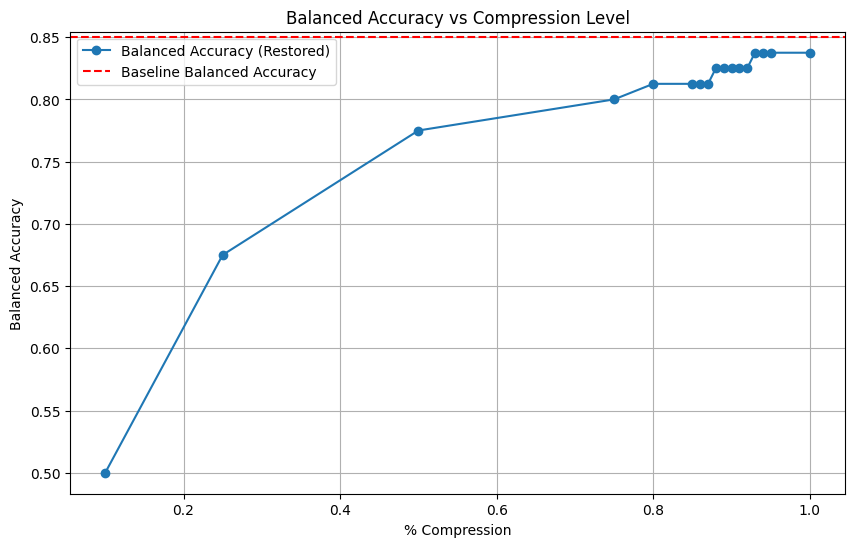

In [21]:
# Crear una visualización
plt.figure(figsize=(10, 6))
plt.plot(results_df['%_compression'], results_df['test_unzipped_score'], marker='o', label='Balanced Accuracy (Restored)')
plt.axhline(y=test_base_score, color='r', linestyle='--', label='Baseline Balanced Accuracy')
plt.xlabel('% Compression')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Compression Level')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Seleccionar el número de componentes con menos de 3 puntos porcentuales de pérdida
acceptable_loss = 0.03  # 3 puntos porcentuales
selected_row = results_df[results_df['difference_test_base'] <= acceptable_loss].sort_values(by='%_compression').head(1)

if not selected_row.empty:
    selected_compression = selected_row.iloc[0]['%_compression']
    selected_n_components = selected_row.iloc[0]['n_components']
    selected = (selected_compression, selected_n_components)
    print(f"\n(Compresión, Número de componentes seleccionados) con pérdida aceptable: {selected}")
else:
    print("\nNo se encontró un número de componentes con una pérdida inferior a 3 puntos porcentuales.")



(Compresión, Número de componentes seleccionados) con pérdida aceptable: (0.88, 36.0)


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)

2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

### Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)

In [23]:
# Aplicar PCA con una compresión del 3%
n_features = X_train.shape[1]
compression = 3.0
n_components = int(n_features * compression / 100)

pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)

(320, 122)


C:\Users\Lander\AppData\Local\Temp\ipykernel_28036\2752099949.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 10)  # Paleta de colores con 10 colores


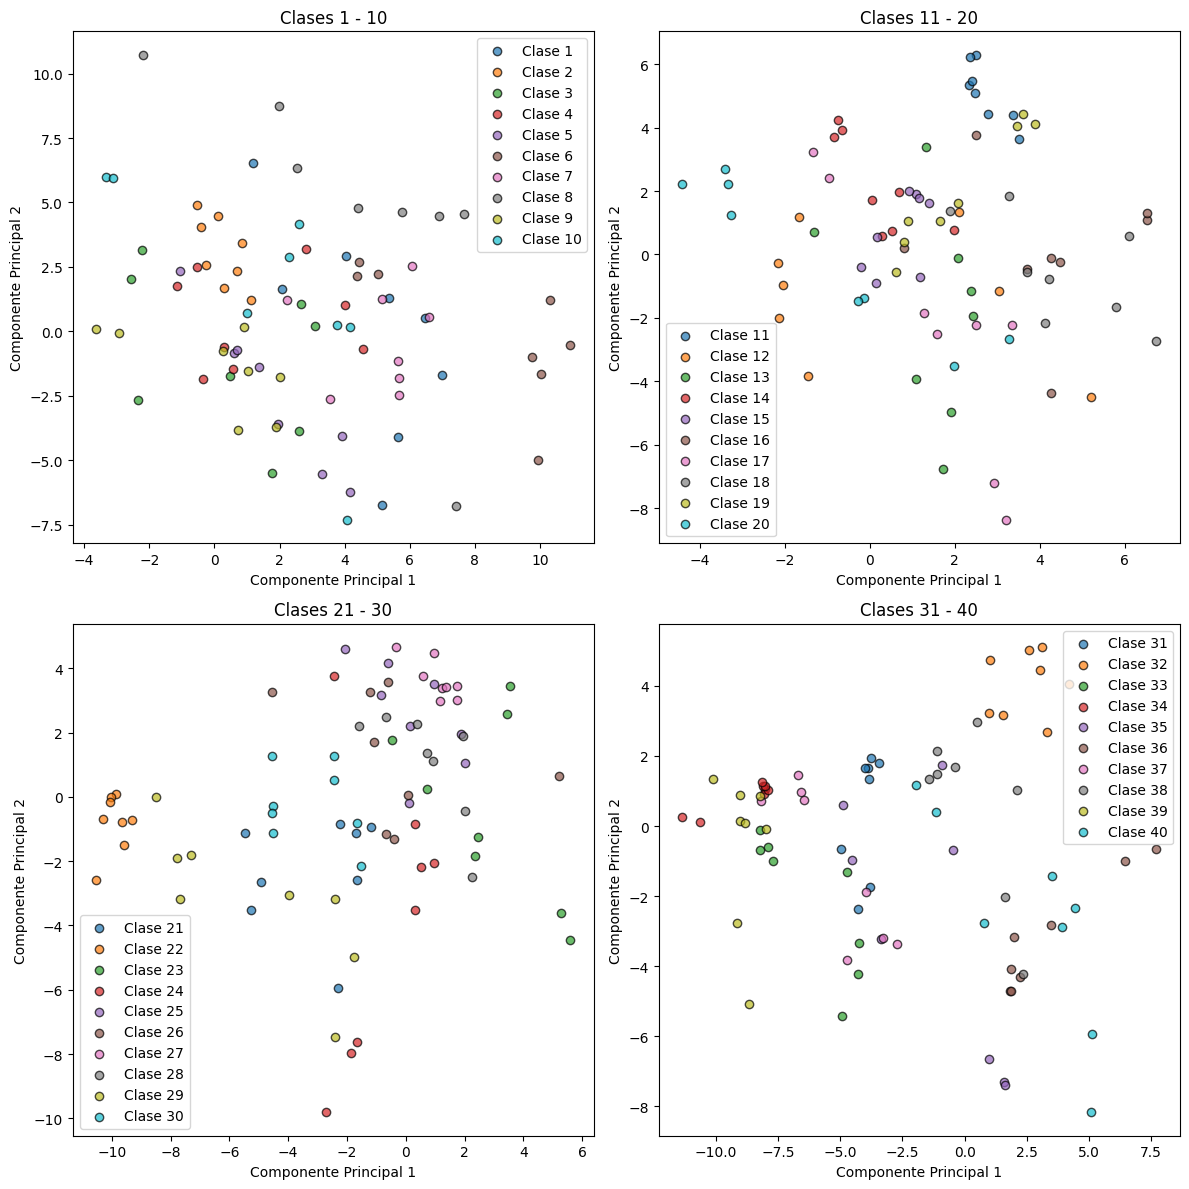

In [24]:
# Para visualizar solo las dos primeras componentes principales
X_train_pca_2d = X_train_pca[:, :2]

# Crear scatter plots por cada grupo de clases (1-10, 11-20, 21-30, 31-40)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

classes = np.unique(y_train)  # Asumiendo que y_train contiene las clases (de 0 a 39)
colors = plt.cm.get_cmap('tab20', 10)  # Paleta de colores con 10 colores

for i, ax in enumerate(axs.ravel()):
    start_class = i * 10
    end_class = (i + 1) * 10
    mask = np.isin(y_train, classes[start_class:end_class])

    # Filtrar los puntos de la PCA que corresponden a las clases en el rango
    X_subset = X_train_pca_2d[mask]
    y_subset = y_train[mask]

    # Graficar cada clase por separado para añadirla a la leyenda
    for class_label in classes[start_class:end_class]:
        class_mask = y_subset == class_label
        ax.scatter(X_subset[class_mask, 0], X_subset[class_mask, 1], label=f'Clase {class_label + 1}',
                   alpha=0.7, edgecolors='k')

    ax.set_title(f'Clases {start_class + 1} - {end_class}')
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.legend()  # Añadir la leyenda para cada gráfico

# Ajustar el espaciado de los gráficos
plt.tight_layout()
plt.show()

Hay algunos grupos que se podrían distinguir, pero... quedarse solo con dos dimensiones de la PCA no parece muy adecuado. Ni  gráficamente como estamos viendo ahora, ni numéricamente como hemos visto antes.

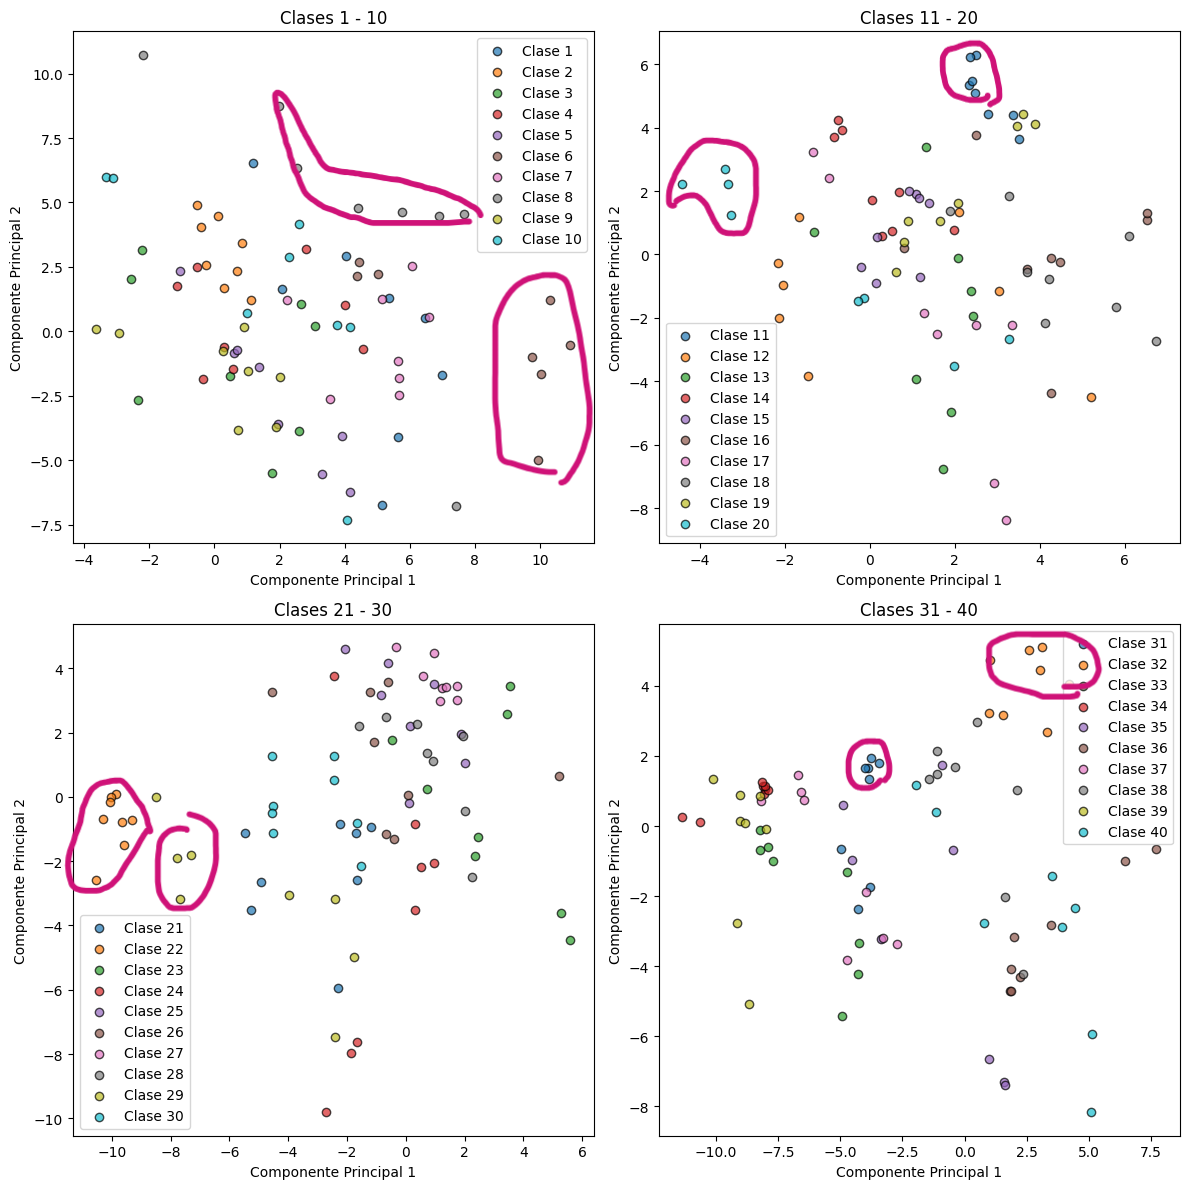

### Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

(%_compression, n_components) = (0.1, 4)


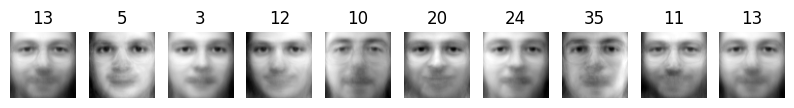

(%_compression, n_components) = (0.5, 20)


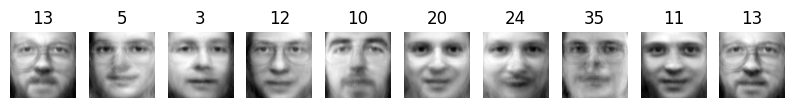

(%_compression, n_components) = (1.0, 40)


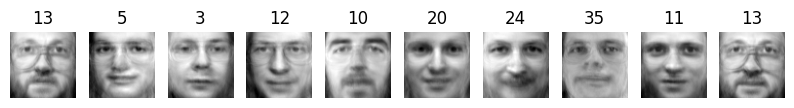

(%_compression, n_components) = (1.5, 61)


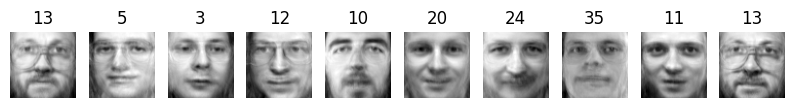

(%_compression, n_components) = (3.5, 143)


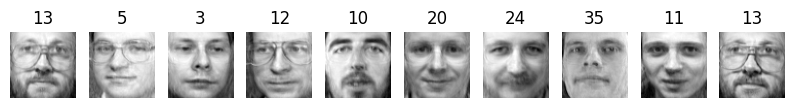

(%_compression, n_components) = (7.5, 307)


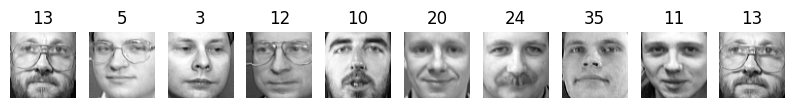


Todos los resultados:


,%_compression,n_components,cv_unzipped_score,test_unzipped_score,difference_cv_base,difference_test_base
0,0.1,4,0.5100,0.5000,0.2625,0.3500
1,0.5,20,0.7525,0.7875,0.0200,0.0625
2,1.0,40,0.8125,0.8375,-0.0400,0.0125
3,1.5,61,0.7975,0.8250,-0.0250,0.0250
4,3.5,143,0.7650,0.8375,0.0075,0.0125
5,7.5,307,0.7725,0.8500,0.0000,0.0000


In [25]:
# Escoger el rango de compresión entre 0.1% y 1%
compression_levels = [0.1, 0.5, 1.0, 1.5, 3.5, 7.5] 
results = []

for compression in compression_levels:
    # Calcular el número de componentes para la compresión actual
    n_components = max(1, int(X_train.shape[1] * (compression / 100)))

    # Aplicar PCA para la compresión
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    
    X_test_pca = pca.transform(X_test)
    X_test_unzipped = pca.inverse_transform(X_test_pca)

    # Entrenar y evaluar el modelo con datos descomprimidos
    knn_unzipped = KNeighborsClassifier()
    cv_unzipped_score = cross_val_score(knn_unzipped, X_train_unzipped, y_train, cv=5, scoring='balanced_accuracy').mean()
    knn_unzipped.fit(X_train_unzipped, y_train)
    test_unzipped_score = balanced_accuracy_score(y_test, knn_unzipped.predict(X_test_unzipped))

    # Almacenar los resultados
    results.append({
        '%_compression': compression,
        'n_components': n_components,
        'cv_unzipped_score': cv_unzipped_score,
        'test_unzipped_score': test_unzipped_score,
        'difference_cv_base': cv_base_score - cv_unzipped_score,
        'difference_test_base': test_base_score - test_unzipped_score
    })
    
    print(f'(%_compression, n_components) = ({compression}, {n_components})')
    fun.plot_faces(X_train_unzipped[:10], y_train[:10])

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar todos los resultados
print("\nTodos los resultados:")
display(results_df)

Encuentro que cuando hemos comprimido mucho la imagen, al descomprimirla se pierde información. Imagino que será por el error de cálculo inherente a las operaciones y transformaciones.